# Predicción series temporales. LSTM

En este notebook se llevará a cabo la implementación de una LSTM, con el objetivo de realizar la predicción de la evolución de una serie temporal. En particular, se desea realizar la predicción de la señal de saturación de la poligrafía nocturna. Para ello, se comparará el rendimiento con dos modelos diferentes, uno que utiliza dos señales de entrada (pulso y saturación), y otro que utiliza únicamente la señal de saturación como entrada.

Para hacer uso de este notebook es necesario generar previamente los datasets, haciendo uso del notebook *generar_dataset_lstm.ipynb*

In [1]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.metrics import accuracy_score

import seaborn as sns
import utils
import pickle
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#CF9962", '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']) 

In [2]:
def build_model(path_checkpoint, train_x, train_y, val_x, val_y):
	"""Función para crear y entrenar un modelo usando la librería Keras

	En los parámetros de la función se reciben los conjuntos de entrenamiento y
	de validación. Lo parámetros del modelo que se crea se pueden ajustar
	dentro de la propia función.

	Args:
		path_checkpoint (str):
			Directorio donde se almacenará el modelo con el menor error en el 
			conjunto de validación.

		train_x (list):  
			Lista con los valores de entrada de cada muestra del conjunto de
			entrenamiento.

		train_y (list):  
			Lista con los valores de salida de cada muestra del conjunto de
			entrenamiento.

		val_x (list):  
			Lista con los valores de entrada de cada muestra del conjunto de
			validacion.

		val_y (list):  
			Lista con los valores de salida de cada muestra del conjunto de
			validacion.
	"""
	# A continuación, se crea el modelo con unos determinados hiperparámetros (se pueden modificar)
	verbose, epochs, batch_size = 1, 50, 128
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

	model = Sequential()
	model.add(LSTM(200, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True))
	model.add(Dropout(0.2))
	model.add(LSTM(units=100, activation='tanh', input_shape=(n_timesteps, n_features)))
	model.add(Dropout(0.2))
	model.add(Dense(n_outputs, activation="tanh"))
	model.compile(loss='mse', optimizer='adam')

	checkpoint = ModelCheckpoint(path_checkpoint, monitor='val_loss', verbose=verbose, save_best_only=True, mode='min')

	# Si en las 10 ultimas épocas no ha mejorado, paro el entrenamiento
	# En caso de querer usar Early stop, podemos hacerlo con la siguiente linea de codigo
	# early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=50, verbose=verbose, mode='min', restore_best_weights=True)

	callbacks_list = [checkpoint]
	history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(val_x, val_y), callbacks=callbacks_list)

	return model, history
	
def summarize_scores(score, scores):
	"""Realiza el resumen de los resultados del RMSE

	Dado el RMSE global, y el RMSE en función de la distancia a la predicción,
	se representa gráficamente el mismo.

	Args:
		score (int):
			RMSE de todo el conjunto de datos.

		scores (list):
			lista que representa los valores del RMSE en función de la 
			distancia a la predicción.
			
    See Also:
        evaluate_forecasts().
	"""
	s_scores = ', '.join(['%.2f' % s for s in scores])
	print('Root Mean Squared Error: [%.3f]. RMSE in predictions at n step %s' % (score, s_scores))

	# Estableces el numero de ticks en el eje horizontal, así como el nombre de los ticks
	if len(scores) > 1:
		labels = [f"{round((i+1)*time_step, 1)}" for i in range(len(scores))]
		num_ticks = 10
		ticks_step = int(len(labels)/num_ticks)
		x_ticks_pos = list(range(len(labels)))[::ticks_step]
		x_ticks_label = labels[::ticks_step]
		plt.xticks(x_ticks_pos, x_ticks_label)

	plt.plot(scores, marker='o', label='MLP', color="C0")
	plt.ylabel("RMSE")
	plt.xlabel("Seconds")
	plt.title("Evolucion RMSE en función de distancia de valor predicho")
	plt.show()

def evaluate_forecasts(actual, predicted):
	"""Calcula el RMSE dada las predicciones y los valores reales

	A partir de las predicciones y los valores reales, se calcula tanto el RMSE
	global del modelo, como el RMSE a cada una de las distancias disponibles
	en la predicción.

	Args:
		actual (list):
			Lista con los valores reales de la salida de las muestras del
			conjunto de datos.

		predicted (list):
			Lista con los valores predecidos de la salida de las muestras del
			conjunto de datos.

	Returns:
		list: 
			El primer elemento representa el RMSE de todo el conjunto de datos, 
			y el segundo elemento de la lista es una lista que representa los
			valores del RMSE en función de la distancia a la predicción. 
	"""
	scores = list()

	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [3]:
def confusion_matrix(actual, predicted, savefig, accepted_error):
    """Calcula la matriz de confusión dada las predicciones y los valores reales

	A partir de las predicciones y los valores reales, se calcula la matriz de
    confusión (tanto usando valores absolutos como en forma de porcentaje).

    Args:
        actual (list):
            Lista con los valores reales de la salida de las muestras del
            conjunto de datos.

        predicted (list):
            Lista con los valores predecidos de la salida de las muestras del
            conjunto de datos.
        
        savefig (bool):
            Indica si se quiere almacenar el gráfico del resultado en un 
            fichero pdf.
        
        accepted_error (int):
            Indica el número de predicciones adelantadas de error que se tolera.
            Es decir, si se predice que va a haber una desaturación, y no la hay,
            pero si hay una desaturación en las siguientes accepted_error muestras,
            se toma como acierto.

    Returns:
        list: 
            Se devuelven las matrices de confusión (en formato de valor absoluto 
            y en formato de porcentaje). 
    """
    # Calculo la matriz de confusión tradicional
    data = {'y_Actual': actual, 'y_Predicted': predicted}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.title("Matriz de confusión")
    sns.heatmap(confusion_matrix, annot=True, cmap=utils.color_map(), fmt='g')
    if savefig: plt.savefig(f"confusion_matriz_normal_{accepted_error}.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 0.025)

    plt.show()

    # Calculo la matriz de confusión con porcentajes
    df_copy = deepcopy(confusion_matrix)
    for col in df_copy.columns:
        df_copy[col] /= sum(df_copy[col])

    df_copy = np.round(df_copy, 2)
    plt.title("Matriz de confusión")

    sns.heatmap(df_copy, annot=True, cmap=utils.color_map(), fmt='g')

    if savefig: plt.savefig(f"confusion_matriz_porcentaje_{accepted_error}.pdf", transparent=True, bbox_inches = 'tight',pad_inches = 0.025)

    plt.show()

    return confusion_matrix, df_copy # Devuelvo las dos matrices de confusion (con porcentajes y con valores absolutos)

def calcular_estadisticas_desaturaciones(actual, predicted, threshold_desaturacion = 4, accepted_error=0, savefig=False):
    """Calcula las matrices de confusión y accuracy

	A partir de las predicciones y los valores reales, se calculan las desaturaciones
    que se han predicho de forma correcta, y se calcula la matriz de confusión 
    (tanto usando valores absolutos como en forma de porcentaje), como el acierto
    global del modelo.


    Args:
        actual (list):
            Lista con los valores reales de la salida de las muestras del
            conjunto de datos.

        predicted (list):
            Lista con los valores predecidos de la salida de las muestras del
            conjunto de datos.
        
        threshold_desaturacion (int):
            Indica la caida en el nivel de saturación que se considera una 
            desaturación.

        savefig (bool):
            Indica si se quiere almacenar el gráfico del resultado en un 
            fichero pdf.
        
        accepted_error (int):
            Indica el número de predicciones adelantadas de error que se tolera.
            Es decir, si se predice que va a haber una desaturación, y no la hay,
            pero si hay una desaturación en las siguientes accepted_error muestras,
            se toma como acierto.

    Returns:
        int: 
            Porcentaje de acierto del modelo.
    
    See Also:
        confusion_matrix().
    """
    # Compruebo si la diferencia entre el mayor y el menor es mayor que el threshold indicado. Esto representa una desaturación.
    desaturaciones_real = (np.max(actual, axis=1) - np.min(actual, axis=1)) > threshold_desaturacion
    desaturaciones_predicted = (np.max(predicted, axis=1) - np.min(predicted, axis=1)) > threshold_desaturacion
    
    # Miro qué muestras ha predicho correctamente
    posiciones_desaturaciones_real = np.where(desaturaciones_real == True)[0]
    posiciones_desaturaciones_predicted = np.where(desaturaciones_predicted == True)[0]

    # Tengo en cuenta el error aceptado
    current = np.array([])
    for i in range(accepted_error):
        current = np.union1d(current, posiciones_desaturaciones_predicted+i+1)

    new_posiciones_desaturaciones_predicted = np.setdiff1d(current, posiciones_desaturaciones_predicted)

    # Calculo cuales de las nuevas posiciones con el error aceptado habrian sido acierto
    interseccion = np.intersect1d(new_posiciones_desaturaciones_predicted, posiciones_desaturaciones_real).astype(int)

    # Las que habrian sido acierto, las pongo a true
    desaturaciones_predicted[interseccion] = True

    confusion_matrix(desaturaciones_real, desaturaciones_predicted, savefig, accepted_error)

    return accuracy_score(desaturaciones_real, desaturaciones_predicted)

In [4]:
# Time_step entre una observación y la siguiente en nuestro conjunto de datos
time_step = 1/3 

# Directorio donde se encuentra nuestro conjunto de datos, y los modelos entrenados
lstm_dir = "lstm"

# Establecemos el tamaño de letra de las gráficas
utils.set_font_size(plt, 14)

# Modelo multivariable

En primer lugar, se muestra el proceso de entrenamiento y evaluación utilizando el modelo multivariable. En este modelo, cada muestra del dataset utiliza como entrada las señales de pulso y saturacion.

In [5]:
# Cargamos el dataset que previamente hemos exportado
with open(f"{lstm_dir}/dataset_multivariable.pickle", "rb") as handle:
    x_train, y_train, x_test, y_test, x_val, y_val, scaler = pickle.load(handle)

In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((49822, 90, 2),
 (49822, 30),
 (16606, 90, 2),
 (16606, 30),
 (16611, 90, 2),
 (16611, 30))

En la celda anterior, podemos ver los tamaños de los conjuntos de datos de entrenamiento, test y validación.

Podemos observar como la tercera dimensión de los datos de entrada al modelo son 2, debido a que la entrada al modelo son dos señales; La de la saturación y la del pulso.

## Entrenamiento y carga del modelo

In [7]:
# Directorio donde se ha almacenado el modelo con menor error en el conjunto de validación
path_checkpoint = f"{lstm_dir}/tmp_checkpoint_lstm_200_100/"

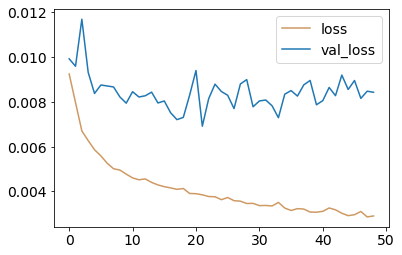

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 90, 200)           162400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 285,830
Trainable params: 285,830
Non-trainable params: 0
_________________________________________________________________


In [8]:
train_model = False
utils.create_dir_if_not_exists(path_checkpoint)
if train_model:
    model, history = build_model(path_checkpoint=path_checkpoint, train_x=x_train, train_y=y_train, val_x=x_val, val_y=y_val)
    model.save(f"{path_checkpoint}model.h5")
    with open(os.path.join(path_checkpoint, "history.pickle"), "wb") as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    plt.plot(history.history["loss"][1:], label="loss")
    plt.plot(history.history["val_loss"][1:], label="val_loss")
    plt.legend()
    plt.show()
else:
    model = load_model(path_checkpoint)
    with open(f"{path_checkpoint}/history.pickle", "rb") as handle:
        history = pickle.load(handle)

    plt.plot(history["loss"][1:], label="loss")
    plt.plot(history["val_loss"][1:], label="val_loss")
    plt.legend()
    plt.show()

model.summary()

## Calculo error del modelo y matrices de confusión

Una vez entrenado el modelo y habiendo visto la evolución del error sobre los conjuntos de entrenamiento y de test, procedemos a calcular el error para todos los conjuntos, invertir el escalado realizado sobre los datos, y calcular las matrices de confusión del modelo.

In [9]:
predicted_train = model.predict(x_train)
predicted_val = model.predict(x_val)
predicted_test = model.predict(x_test)

In [10]:
mean_squared_error(y_train, predicted_train), mean_squared_error(y_val, predicted_val), mean_squared_error(y_test, predicted_test)

(0.0031845752206346016, 0.006906557163040785, 0.005251926102258853)

In [11]:
# Invertimos transformacion
predicted_train_transform = scaler.inverse_transform(predicted_train)
predicted_test_transform = scaler.inverse_transform(predicted_test)
predicted_val_transform = scaler.inverse_transform(predicted_val)

y_train_transform = scaler.inverse_transform(y_train)
y_test_transform = scaler.inverse_transform(y_test)
y_val_transform = scaler.inverse_transform(y_val)

In [12]:
mean_squared_error(y_train_transform, predicted_train_transform), mean_squared_error(y_val_transform, predicted_val_transform), mean_squared_error(y_test_transform, predicted_test_transform)

(1.4043976825986315, 3.045791735159602, 2.3160994472976637)

Root Mean Squared Error: [1.522]. RMSE in predictions at n step 0.41, 0.47, 0.53, 0.60, 0.67, 0.74, 0.82, 0.90, 0.98, 1.07, 1.14, 1.22, 1.30, 1.37, 1.45, 1.52, 1.59, 1.65, 1.72, 1.77, 1.83, 1.88, 1.93, 1.98, 2.02, 2.07, 2.11, 2.15, 2.19, 2.23


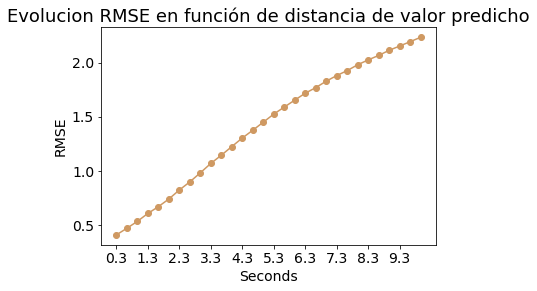

In [13]:
score, scores = evaluate_forecasts(actual=y_test_transform, predicted=predicted_test_transform)
summarize_scores(score, scores)

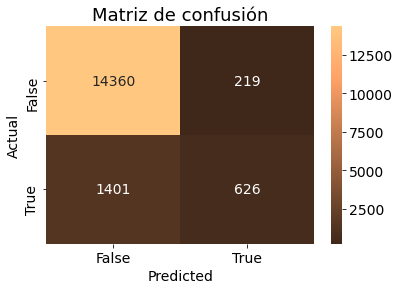

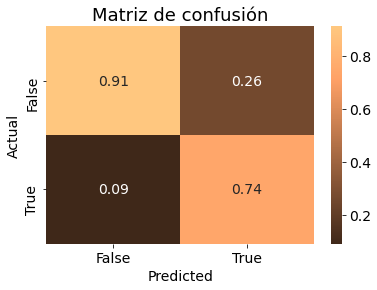

0.9024448994339396

In [14]:
calcular_estadisticas_desaturaciones(actual=y_test_transform, predicted=predicted_test_transform, threshold_desaturacion = 4, savefig=False, accepted_error=1)

# Modelo univariable

Podemos realizar el mismo proceso de entrenamiento con el modelo multivariable. A continuación, se muestra el proceso de carga de los datos del modelo univariable, y los resultados obtenidos. En este modelo, cada muestra del dataset utiliza como entrada únicamente la señal del pulso.

In [15]:
# Cargamos el dataset que previamente hemos exportado
with open(f"{lstm_dir}/dataset_univariable.pickle", "rb") as handle:
    x_train, y_train, x_test, y_test, x_val, y_val, scaler = pickle.load(handle)

In [16]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((49822, 90, 1),
 (49822, 30),
 (16606, 90, 1),
 (16606, 30),
 (16611, 90, 1),
 (16611, 30))

En la celda anterior, podemos ver los tamaños de los conjuntos de datos de entrenamiento, test y validación.

## Entrenamiento y carga del modelo

In [17]:
# Directorio donde se ha almacenado el modelo con menor error en el conjunto de validación
path_checkpoint = f"{lstm_dir}/tmp_checkpoint_lstm_150/"

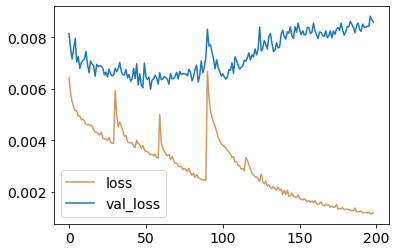

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                4530      
Total params: 95,730
Trainable params: 95,730
Non-trainable params: 0
_________________________________________________________________


In [18]:
train_model = False
utils.create_dir_if_not_exists(path_checkpoint)
if train_model:
    model, history = build_model(path_checkpoint=path_checkpoint, train_x=x_train, train_y=y_train, val_x=x_val, val_y=y_val)
    model.save(f"{path_checkpoint}model.h5")
    with open(os.path.join(path_checkpoint, "history.pickle"), "wb") as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    plt.plot(history.history["loss"][1:], label="loss")
    plt.plot(history.history["val_loss"][1:], label="val_loss")
    plt.legend()
    plt.show()
else:
    model = load_model(path_checkpoint)
    with open(f"{path_checkpoint}/history.pickle", "rb") as handle:
        history = pickle.load(handle)

    plt.plot(history["loss"][1:], label="loss")
    plt.plot(history["val_loss"][1:], label="val_loss")
    plt.legend()
    plt.show()

model.summary()

En la gráfica superior vemos una tendencia al sobreajuste. Por este motivo, se ha hecho uso del checkpoint, con el que nos hemos quedado con el modelo con un menor error en el conjunto de validación.

## Calculo error del modelo y matrices de confusión

Una vez entrenado el modelo y habiendo visto la evolución del error sobre los conjuntos de entrenamiento y de test, procedemos a calcular el error para todos los conjuntos, invertir el escalado realizado sobre los datos, y calcular las matrices de confusión del modelo.

In [19]:
predicted_train = model.predict(x_train)
predicted_val = model.predict(x_val)
predicted_test = model.predict(x_test)

In [20]:
mean_squared_error(y_train, predicted_train), mean_squared_error(y_val, predicted_val), mean_squared_error(y_test, predicted_test)

(0.003428338368256925, 0.0056562502789679085, 0.005701610908712672)

In [21]:
# Invertimos transformacion
predicted_train_transform = scaler.inverse_transform(predicted_train)
predicted_test_transform = scaler.inverse_transform(predicted_test)
predicted_val_transform = scaler.inverse_transform(predicted_val)

y_train_transform = scaler.inverse_transform(y_train)
y_test_transform = scaler.inverse_transform(y_test)
y_val_transform = scaler.inverse_transform(y_val)

In [22]:
mean_squared_error(y_train_transform, predicted_train_transform), mean_squared_error(y_val_transform, predicted_val_transform), mean_squared_error(y_test_transform, predicted_test_transform)

(1.5847493845196288, 2.6146016987162026, 2.63556959456018)

Root Mean Squared Error: [1.623]. RMSE in predictions at n step 0.35, 0.43, 0.51, 0.58, 0.65, 0.73, 0.82, 0.91, 0.99, 1.09, 1.17, 1.26, 1.35, 1.43, 1.51, 1.60, 1.67, 1.74, 1.81, 1.89, 1.95, 2.02, 2.08, 2.13, 2.20, 2.25, 2.30, 2.35, 2.40, 2.44


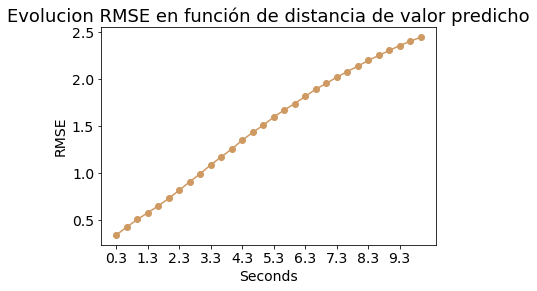

In [23]:
score, scores = evaluate_forecasts(actual=y_test_transform, predicted=predicted_test_transform)
summarize_scores(score, scores)

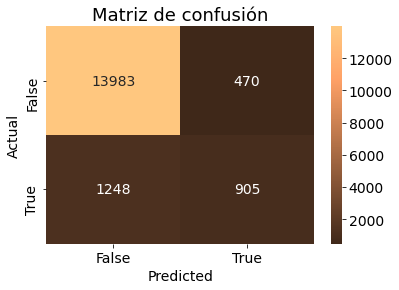

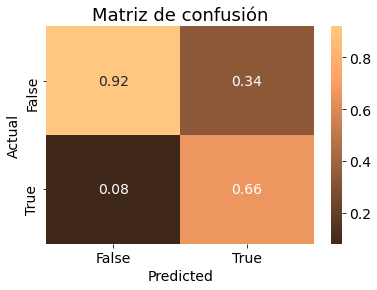

0.8965434180416717

In [24]:
calcular_estadisticas_desaturaciones(actual=y_test_transform, predicted=predicted_test_transform, threshold_desaturacion = 4, savefig=False, accepted_error=1)

Podemos observar como la tasa de verdaderos positivos obtenida usando el modelo que solo toma como entrada información de la señal de saturación es menor que la del modelo que usa las señales de saturación y pulso (66% frente a 74%)